### interference using pre-trained kmeans model



### Introduction

This notebook allows users to perform interference on a pre-trainined kmeans cluster model.  The model was previously trained on FastFuels data from the experimental Blodgett Forest region (bounding box: lat1 = 38.883575, lon1 = -120.65020833333334, lat2 = 38.86849, lon2 = -120.63286).

In this interference notebook, the kmeans model object is opened and along with FastFuels data from the Lake Tahoe region and inference is performed on the new data.

Interference is performed on this geographic locationin Lake Tahoe: Bounding box (lon1 = -120.21303, lat1 = 39.21391, lon2 = -120.1959, lat2 = 39.19940)

In [2]:
import zarr
import s3fs
import fastfuels
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
import ipyparams
import ckanapi
import os
import pickle


<IPython.core.display.Javascript object>

### load model

In [9]:
kmeans_model = pickle.load(open("kmeans_model_total_fuels_ground_midstory.pkl", "rb"))

### load new data

In [4]:
### loading-data-from-minio-server

s3 = s3fs.S3FileSystem(client_kwargs={
                        "endpoint_url": "https://wifire-data.sdsc.edu:9000",
                        "verify": False
                       },
                       username=os.getenv('username'), 
                       password=os.getenv('password'))   

In [5]:
store = s3fs.S3Map(root='/ca.fio', s3=s3, check=False)
z = zarr.group(store=store)

### convert from lat/long coords to indices of fuel array data

In [6]:
def coordinates_to_indices(lat1,lon1,lat2,lon2):
    
    """
    inputs: takes in lat/lon coordinates
    outputs: fuel array indices
    """

    # Performs forward projection from geodetic coordinates to projected coordinates

    A=fastfuels.core.AlbersEqualAreaConic()

    x1, y1 = A.forward(lat1, lon1)
    x2, y2 = A.forward(lat2, lon2)


    #get extent

    extent_x1, extent_y1, extent_x2, extent_y2 = z.attrs['extent']

    # calculate indices of fuel array

    x1_rel = int(x1 - extent_x1)
    y1_rel = int(extent_y1 - y1)
    x2_rel = int(x2 - extent_x1)
    y2_rel = int(extent_y1 - y2)

    return x1_rel,y1_rel, x2_rel,y2_rel

### generate 3d canopy data for region near Lake Tahoe 

In [96]:
# choose location near lake tahoe
lon1 = -120.21303
lat1 = 39.21391

#lon2 = -120.1926
#lat2 = 39.20831
lon2 = -120.1959
lat2 = 39.19940


# convert coordinates
x1_rel,y1_rel, x2_rel,y2_rel = coordinates_to_indices(lat1,lon1,lat2,lon2)

# get data array for that region
data_lake_tahoe_3d_canopy_sav = z['canopy']['sav'][y1_rel:y2_rel, x1_rel:x2_rel, :]

In [97]:
data_lake_tahoe_3d_canopy_sav.shape

(1943, 1009, 128)

### define ground/midstory

In [98]:
# ground/midstory - the voxels <= 3 meters (sav)
ground_midstory = data_lake_tahoe_3d_canopy_sav[:,:,0:4]

In [99]:
ground_midstory.shape

(1943, 1009, 4)

### calculate total fuels

In [100]:
# Convert all non-zero voxel values to 1.  Call numpy.where(condition, x, y) to replace values that meet condition with x, and those that do not with y.

ground_midstory_values_to_1 = np.where(ground_midstory > 0, 1, 0)


# sum array elements over the z-axis (axis=2) to get aggregate sum of number of voxels in given z-axis column and project onto 2-d x,y plane
total_fuels_ground_midstory = np.sum(ground_midstory_values_to_1, axis = 2)


In [101]:
total_fuels_ground_midstory.shape

(1943, 1009)

In [ ]:
#reshape to 1007 features to match original in model object

In [102]:
total_fuels_ground_midstory_ = total_fuels_ground_midstory[:,:1007]

### inference using kmeans model

In [104]:
kmeans_model.predict(total_fuels_ground_midstory_)
cluster_centers_ground_midstory_tf = kmeans_model.cluster_centers_
cluster_labels_ground_midstory_tf = kmeans_model.labels_

### visualize results

Text(0.5, 1.0, 'clustered (n=4)')

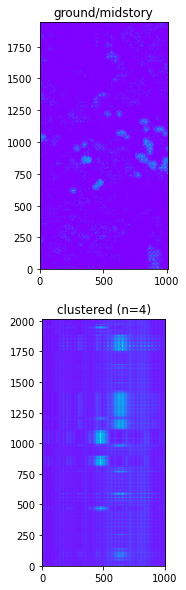

In [107]:
fig, ax = plt.subplots(2,1,figsize=(14,10))

# move zeros to -1 for thresholding
total_fuels_ground_midstory_[total_fuels_ground_midstory_ == 0] = -1

ax[0].imshow(total_fuels_ground_midstory[:,:1007], cmap='rainbow', origin="lower")
ax[0].set_title('ground/midstory')

ax[1].imshow(cluster_centers_ground_midstory_tf[cluster_labels_ground_midstory_tf], cmap='rainbow', origin="lower")
ax[1].set_title('clustered (n=4)')